In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from PIL import Image
import os
import numpy as np
from  custom_dataset  import CustomDataset
from tqdm import tqdm
from reward_model import RewardModel
import timeit
from sklearn.metrics import top_k_accuracy_score
import pandas as pd
from utils import save_model
from torchsummary import summary
import random
from sklearn.model_selection import KFold
from custom_dataset2 import CustomDataset2
# random_seed = 42
# torch.manual_seed(random_seed)

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def setup_seed( cuda,seed=42):
    # Creates global random seed across torch, cuda and numpy 
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic=True


In [4]:
setup_seed(cuda=device)

In [5]:
# Settings
img_size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [6]:

# df = pd.read_csv('test_custom_dataset.csv', sep=';', header=None)
df = pd.read_csv('data/ranking_dataset_outlier_rem.csv', sep=',', header=None)

#df = df.drop(labels=0, axis=0)
df.head()


,0,1
0,IM_bTkVTbpcDgYoRJA,2
1,IM_mHXwAfdWoPQfqAN,3
2,IM_JL0VD0AuSA2Glrs,4
3,IM_wd5NoxRxawdAN9L,8
4,IM_BahdUhDKLPY0xJ9,1


In [7]:
train = pd.read_csv('data/train.csv', sep=',', header=None)


train.head()


,0,1
0,IM_bTkVTbpcDgYoRJA,4
1,IM_mHXwAfdWoPQfqAN,2
2,IM_JL0VD0AuSA2Glrs,3
3,IM_wd5NoxRxawdAN9L,6
4,IM_BahdUhDKLPY0xJ9,1


In [8]:
# Create transform
normalize = transforms.Normalize(mean=mean,
                                    std=std)
transform = transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ])


# Load data
# dataset = CustomDataset(data_file='data/ranking_dataset_outlier_rem.csv',image_folder_prototype='prototype_acts', image_folder_inputx = 'prototype_input_img', transform=transform) 
# print(len(dataset))

train_set = CustomDataset(data_file='data/train.csv',image_folder_prototype='prototype_acts', image_folder_inputx = 'prototype_input_img', transform=transform) 
print(len(train_set))

test_set = CustomDataset(data_file='data/test.csv',image_folder_prototype='prototype_acts', image_folder_inputx = 'prototype_input_img', transform=transform) 
print(len(test_set))



2640
280


In [9]:
# Hyperparameters
train_batch_size = 128
test_batch_size = 128
num_epochs = 5
lr = 0.0001
t_max = ((len(train_set)/train_batch_size)*num_epochs)/2
print('t_max: ', t_max)
seed=42

t_max:  51.5625


In [10]:

dataloaders = {
    'train':
    torch.utils.data.DataLoader(
    train_set, batch_size=train_batch_size, shuffle=True,
    num_workers=4, pin_memory=False),
    'test':
    torch.utils.data.DataLoader(
    test_set, batch_size=test_batch_size, shuffle=False,
    num_workers=4, pin_memory=False)
    }



In [11]:
input_size_1 = (1,7,7)
input_size_2 = (3,224,224)

#### INIT MODEL ####
model = RewardModel(input_size_1,input_size_2)
model.to(device=device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=t_max)


In [12]:

# Print the model summary with two inputs
summary(model, input_size=[input_size_1, input_size_2])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 32, 7, 7]             320
              ReLU-2             [-1, 32, 7, 7]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
              ReLU-4             [-1, 64, 7, 7]               0
         MaxPool2d-5             [-1, 64, 3, 3]               0
            Conv2d-6         [-1, 32, 224, 224]             896
              ReLU-7         [-1, 32, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          18,496
              ReLU-9         [-1, 64, 224, 224]               0
        MaxPool2d-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]          73,856
             ReLU-12        [-1, 128, 112, 112]               0
        MaxPool2d-13          [-1, 128, 56, 56]               0
           Linear-14                  [

In [13]:
def train_model(model, optimizer, scheduler, criterion, dataloaders, num_epochs):

    train_msa = []
    train_loss_lst = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        dataset_size = 0
        for phase in ['train']:
            
            start = timeit.default_timer()

            dataset_size = len(train_set)
            model.train()

            running_loss = 0.0
            running_rsme_loss = 0.0


            for i, (prototype, labels, inputx) in enumerate(tqdm(dataloaders[phase])):

                prototype = prototype.to(device=device)
                inputx = inputx.to(device=device)
                labels = labels.to(device=device)
                
                labels = labels.to(torch.float32)
                labels =  labels.unsqueeze(1)
          
                outputs = model(prototype,inputx)

                loss = criterion(outputs, labels)
                rsme = torch.sqrt(loss)



                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item() 
                running_rsme_loss += rsme.item()

            scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_rsme = running_rsme_loss / dataset_size
    
            train_loss_lst.append(epoch_loss)
 

            print('MSE {} loss: {:.4f}'.format(phase,epoch_loss))
            print('RMSE {} loss: {:.4f}'.format(phase,epoch_rsme))
            

            stop = timeit.default_timer()
            time = stop - start
            print('{} time in s: {} '.format(phase, time) )

    return model,  train_loss_lst

In [14]:
trained_model, loss_lst = train_model(model=model, optimizer=optimizer, criterion=criterion,scheduler=scheduler, dataloaders=dataloaders, num_epochs=num_epochs)
# save_model(trained_model, save_path='./trained_models/')
# print('Model saved')

Epoch 1/5
----------
MSE train loss: 0.1082
RMSE train loss: 0.0283
train time in s: 40.39569934300016 
Epoch 2/5
----------
MSE train loss: 0.0611
RMSE train loss: 0.0220
train time in s: 39.77329781700064 
Epoch 3/5
----------
MSE train loss: 0.0505
RMSE train loss: 0.0200
train time in s: 40.16165310799988 
Epoch 4/5
----------
MSE train loss: 0.0404
RMSE train loss: 0.0179
train time in s: 40.494790711998576 
Epoch 5/5
----------
MSE train loss: 0.0357
RMSE train loss: 0.0168
train time in s: 40.26370519300144 


100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


In [16]:
torch.save(trained_model.state_dict(),  'weights_reward_CV.h5')

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
start = timeit.default_timer()
trained_model.eval()
history = []
mse=0.0
rmse=0.0
with torch.no_grad():
   
    for (prototype, labels, inputx) in tqdm(dataloaders['test']):

        prototype = prototype.to(device=device)
        inputx = inputx.to(device=device)
        labels = labels.to(device=device)
        labels = labels.to(torch.float32)
        labels =  labels.unsqueeze(1)

        outputs = trained_model(prototype, inputx)

        mse_crit = criterion(outputs, labels)
        rmse_crit = torch.sqrt(mse_crit)
        mse += float(mse_crit)
        rmse+= float(rmse_crit)
        history.append(mse)


print(mse/len(test_set))
print(rmse/len(test_set))
stop = timeit.default_timer()
time = stop - start
print('Test time in s: {} '.format(time) )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16it/s]

0.051070421082632884
0.023186240025929044
Test time in s: 2.595136626999988 


In [15]:
def plot_metric(metric_lst : list, metric_name: str, num_epochs: int):
    """
    Plots the metric from metric list

    Parameters
    -----------
        metric_lst : List
            List containing a train metric of the model
        metric_name : str
            Name of the metric to be plotted
        num_epochs : int
            Number of epochs used to train
    
    """
    x = range(0,num_epochs,1)
    plt.plot(x, metric_lst)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title('Train {} reward model'.format(metric_name))
    plt.legend()
    plt.savefig('loss_reward_model_CV.pdf')
    plt.show()
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


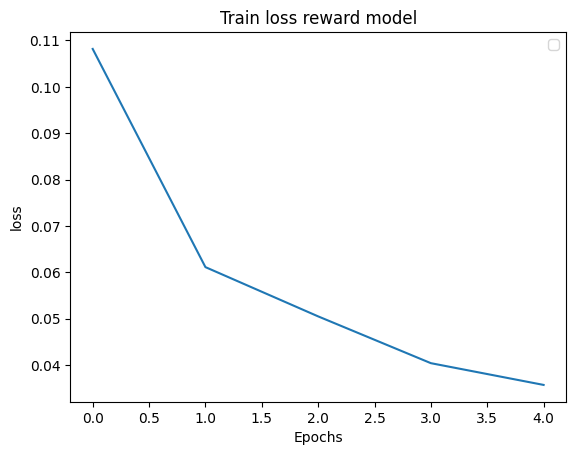

In [16]:
import matplotlib.pyplot as plt
plot_metric(metric_lst=loss_lst, metric_name='loss', num_epochs=num_epochs)

## KFOLD CROSS VALIDATION

In [1]:
########### IMPORTS ###########
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from PIL import Image
import os
import numpy as np
from  custom_dataset  import CustomDataset
from tqdm import tqdm
from reward_model import RewardModel
import timeit
from sklearn.metrics import top_k_accuracy_score
import pandas as pd
from utils import save_model
from torchsummary import summary
import random
from sklearn.model_selection import KFold
from custom_dataset2 import CustomDataset2

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def setup_seed( cuda,seed=42):
    # Creates global random seed across torch, cuda and numpy 
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic=True

In [4]:
setup_seed(cuda=device)

In [5]:
# Settings
img_size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [6]:
# Hyperparameters
train_batch_size = 128
test_batch_size = 128
num_epochs = 15
lr = 0.0001
t_max = ((2112/train_batch_size)*num_epochs)/2
print('t_max: ', t_max)
seed=42

t_max:  123.75


In [7]:
def validate(trained_model, dataloaders, val_set):
   
    start = timeit.default_timer()
    trained_model.eval()
    history = []
    mse=0.0
    rmse=0.0
    with torch.no_grad():
    
        for (prototype, labels, inputx) in tqdm(dataloaders['val']):

            prototype = prototype.to(device=device)
            inputx = inputx.to(device=device)
            labels = labels.to(device=device)
            labels = labels.to(torch.float32)
            labels =  labels.unsqueeze(1)

            outputs = trained_model(prototype, inputx)

            mse_crit = criterion(outputs, labels)
            rmse_crit = torch.sqrt(mse_crit)
            mse += float(mse_crit)
            rmse+= float(rmse_crit)
            history.append(mse)


    # print(mse/len(val_set))
    # print(rmse/len(val_set))
    stop = timeit.default_timer()
    time = stop - start
    mse_final =  mse/len(val_set)
    rmse_final =  rmse/len(val_set)
    print('Validation time in s: {} '.format(time) )
    print('Validation mse score fold {}: {}'.format(i, mse/len(val_set)))
    print('Validation rmse score fold {}: {}'.format(i, rmse/len(val_set)))
    return mse_final, rmse_final

In [8]:
def train_val_model(model, optimizer, scheduler, criterion, dataloaders, num_epochs, train_set):

    train_msa = []
    train_loss_lst = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        model.train()

        start = timeit.default_timer()

        dataset_size = len(train_set)
        model.train()

        running_loss = 0.0
        running_rsme_loss = 0.0


        for i, (prototype, labels, inputx) in enumerate(tqdm(dataloaders['train'])):

            prototype = prototype.to(device=device)
            inputx = inputx.to(device=device)
            labels = labels.to(device=device)
            
            labels = labels.to(torch.float32)
            labels =  labels.unsqueeze(1)
        
            outputs = model(prototype,inputx)

            loss = criterion(outputs, labels)
            rsme = torch.sqrt(loss)



            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() 
            running_rsme_loss += rsme.item()

        scheduler.step()

        epoch_loss = running_loss / dataset_size
        epoch_rsme = running_rsme_loss / dataset_size

        train_loss_lst.append(epoch_loss)

        


        print('MSE {} loss: {:.4f}'.format('train',epoch_loss))
        print('RMSE {} loss: {:.4f}'.format('train',epoch_rsme))

        
        

        stop = timeit.default_timer()
        time = stop - start
        print('{} time in s: {} '.format('train', time) )

    return model,  train_loss_lst

In [9]:
##### INIT MODEL #####
input_size_1 = (1,7,7)
input_size_2 = (3,224,224)
model = RewardModel(input_size_1,input_size_2)
model.to(device=device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=t_max)

In [10]:


##### KFOLD CROSS VALIDATION #####
train_df = pd.read_csv('data/train.csv', sep=',', header=None)
kf = KFold(n_splits=5)
print(kf.get_n_splits(train_df))



normalize = transforms.Normalize(mean=mean,
                                    std=std)
transform = transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ])
mse_fold = []
rmse_fold =[]
for i,(train_index, val_index) in enumerate(kf.split(train_df)):
    train_set_df = train_df.iloc[train_index]
    val_set_df = train_df.iloc[val_index]
    
    train_set = CustomDataset2(data=train_set_df,image_folder_prototype='prototype_acts', image_folder_inputx = 'prototype_input_img', transform=transform) 
    val_set = CustomDataset2(data=val_set_df,image_folder_prototype='prototype_acts', image_folder_inputx = 'prototype_input_img', transform=transform) 
    # print(len(train_set))
    # print(len(val_set))
    
  
    dataloaders = {
    'train':
    torch.utils.data.DataLoader(
    train_set, batch_size=train_batch_size, shuffle=True,
    num_workers=4, pin_memory=False),
    'val':
    torch.utils.data.DataLoader(
    val_set, batch_size=train_batch_size, shuffle=True,
    num_workers=4, pin_memory=False),

    }

    

    trained_model, loss_lst = train_val_model(model=model, optimizer=optimizer, criterion=criterion,scheduler=scheduler, dataloaders=dataloaders, num_epochs=num_epochs,train_set=train_set)

    mse, rsme = validate(trained_model=trained_model, dataloaders=dataloaders, val_set=val_set)
    mse_fold.append(mse)
    rmse_fold.append(rsme)

print("Final MSE: ", mse_fold)
print("Final RMSE: ", rmse_fold)

5
Epoch 1/15
----------


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/17 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.1100
RMSE train loss: 0.0288
train time in s: 30.971169414000542 
Epoch 2/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0670
RMSE train loss: 0.0232
train time in s: 30.876733541999783 
Epoch 3/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.81s/it]


MSE train loss: 0.0564
RMSE train loss: 0.0213
train time in s: 30.82146169800035 
Epoch 4/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.80s/it]


MSE train loss: 0.0455
RMSE train loss: 0.0191
train time in s: 30.67850584000007 
Epoch 5/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0382
RMSE train loss: 0.0175
train time in s: 30.95109839699944 
Epoch 6/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0360
RMSE train loss: 0.0170
train time in s: 30.920219784000437 
Epoch 7/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0348
RMSE train loss: 0.0167
train time in s: 31.01348226600021 
Epoch 8/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0342
RMSE train loss: 0.0166
train time in s: 31.15641503400002 
Epoch 9/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0352
RMSE train loss: 0.0168
train time in s: 31.187481724000463 
Epoch 10/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0340
RMSE train loss: 0.0165
train time in s: 31.064376620000985 
Epoch 11/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0342
RMSE train loss: 0.0166
train time in s: 30.983910703998845 
Epoch 12/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0334
RMSE train loss: 0.0163
train time in s: 31.00052328700076 
Epoch 13/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0335
RMSE train loss: 0.0164
train time in s: 31.13023826099925 
Epoch 14/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.84s/it]


MSE train loss: 0.0327
RMSE train loss: 0.0162
train time in s: 31.253377744000318 
Epoch 15/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0329
RMSE train loss: 0.0163
train time in s: 31.165789718999804 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]


Validation time in s: 3.16877962900071 
Validation mse score fold 0: 0.02908478361187559
Validation rmse score fold 0: 0.01655051586302844
Epoch 1/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.80s/it]


MSE train loss: 0.0309
RMSE train loss: 0.0157
train time in s: 30.64798728599999 
Epoch 2/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.81s/it]


MSE train loss: 0.0303
RMSE train loss: 0.0156
train time in s: 30.82709063100083 
Epoch 3/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0299
RMSE train loss: 0.0155
train time in s: 30.982550857001115 
Epoch 4/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0301
RMSE train loss: 0.0155
train time in s: 30.865179428001284 
Epoch 5/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0297
RMSE train loss: 0.0154
train time in s: 30.894111084000542 
Epoch 6/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.81s/it]


MSE train loss: 0.0306
RMSE train loss: 0.0157
train time in s: 30.76847279300091 
Epoch 7/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.81s/it]


MSE train loss: 0.0296
RMSE train loss: 0.0154
train time in s: 30.716324106000684 
Epoch 8/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.81s/it]


MSE train loss: 0.0299
RMSE train loss: 0.0155
train time in s: 30.758885814999303 
Epoch 9/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.81s/it]


MSE train loss: 0.0298
RMSE train loss: 0.0155
train time in s: 30.801749496999037 
Epoch 10/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0294
RMSE train loss: 0.0153
train time in s: 30.9487390639988 
Epoch 11/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.81s/it]


MSE train loss: 0.0298
RMSE train loss: 0.0155
train time in s: 30.760231628999463 
Epoch 12/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0300
RMSE train loss: 0.0155
train time in s: 30.91015190899998 
Epoch 13/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0303
RMSE train loss: 0.0156
train time in s: 30.908378517999154 
Epoch 14/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.80s/it]


MSE train loss: 0.0296
RMSE train loss: 0.0154
train time in s: 30.595641293999506 
Epoch 15/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0296
RMSE train loss: 0.0154
train time in s: 30.916920672998458 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


Validation time in s: 3.618760265000674 
Validation mse score fold 1: 0.045752547004006126
Validation rmse score fold 1: 0.02071808097940503
Epoch 1/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.78s/it]


MSE train loss: 0.0321
RMSE train loss: 0.0160
train time in s: 30.270916241999657 
Epoch 2/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0315
RMSE train loss: 0.0159
train time in s: 30.928259877000528 
Epoch 3/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0314
RMSE train loss: 0.0158
train time in s: 30.957088568999097 
Epoch 4/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0318
RMSE train loss: 0.0159
train time in s: 30.90511641899866 
Epoch 5/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0308
RMSE train loss: 0.0157
train time in s: 30.977635520999684 
Epoch 6/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.84s/it]


MSE train loss: 0.0312
RMSE train loss: 0.0158
train time in s: 31.22720005500014 
Epoch 7/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0311
RMSE train loss: 0.0158
train time in s: 30.92529096800172 
Epoch 8/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0308
RMSE train loss: 0.0157
train time in s: 31.052359315001013 
Epoch 9/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0309
RMSE train loss: 0.0157
train time in s: 30.94462164500146 
Epoch 10/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0310
RMSE train loss: 0.0158
train time in s: 30.94782758099973 
Epoch 11/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0310
RMSE train loss: 0.0158
train time in s: 30.905469575000097 
Epoch 12/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0305
RMSE train loss: 0.0156
train time in s: 30.931456070000422 
Epoch 13/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0306
RMSE train loss: 0.0157
train time in s: 31.002818106000632 
Epoch 14/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0313
RMSE train loss: 0.0158
train time in s: 31.064059053000165 
Epoch 15/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0307
RMSE train loss: 0.0157
train time in s: 31.105978778999997 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s]


Validation time in s: 3.5440792919998785 
Validation mse score fold 2: 0.03696154238599719
Validation rmse score fold 2: 0.018517695141561104
Epoch 1/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.79s/it]


MSE train loss: 0.0283
RMSE train loss: 0.0151
train time in s: 30.427467741999862 
Epoch 2/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.82s/it]


MSE train loss: 0.0277
RMSE train loss: 0.0149
train time in s: 31.01357284200094 
Epoch 3/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.82s/it]


MSE train loss: 0.0268
RMSE train loss: 0.0147
train time in s: 31.02511867300018 
Epoch 4/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0265
RMSE train loss: 0.0146
train time in s: 31.041825637999864 
Epoch 5/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.82s/it]


MSE train loss: 0.0265
RMSE train loss: 0.0146
train time in s: 31.016197396998905 
Epoch 6/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0266
RMSE train loss: 0.0146
train time in s: 30.958276837000085 
Epoch 7/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0263
RMSE train loss: 0.0145
train time in s: 31.09412242200051 
Epoch 8/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0264
RMSE train loss: 0.0145
train time in s: 30.928794595 
Epoch 9/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0262
RMSE train loss: 0.0145
train time in s: 30.977151175000472 
Epoch 10/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.81s/it]


MSE train loss: 0.0261
RMSE train loss: 0.0144
train time in s: 30.810658983000394 
Epoch 11/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0261
RMSE train loss: 0.0145
train time in s: 30.971063598999535 
Epoch 12/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0262
RMSE train loss: 0.0145
train time in s: 30.872176463999494 
Epoch 13/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.81s/it]


MSE train loss: 0.0262
RMSE train loss: 0.0145
train time in s: 30.83265601899984 
Epoch 14/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0260
RMSE train loss: 0.0144
train time in s: 31.094133877000786 
Epoch 15/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.81s/it]


MSE train loss: 0.0262
RMSE train loss: 0.0145
train time in s: 30.863932657999612 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]


Validation time in s: 3.522871288998431 
Validation mse score fold 3: 0.07788770758744443
Validation rmse score fold 3: 0.02707817473194816
Epoch 1/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.80s/it]


MSE train loss: 0.0317
RMSE train loss: 0.0159
train time in s: 30.589186270999562 
Epoch 2/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0295
RMSE train loss: 0.0154
train time in s: 31.087763896999604 
Epoch 3/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0284
RMSE train loss: 0.0151
train time in s: 30.98682197999915 
Epoch 4/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0278
RMSE train loss: 0.0149
train time in s: 30.93208682799923 
Epoch 5/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0270
RMSE train loss: 0.0147
train time in s: 30.903656450998824 
Epoch 6/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.82s/it]


MSE train loss: 0.0265
RMSE train loss: 0.0146
train time in s: 31.011050387998694 
Epoch 7/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0263
RMSE train loss: 0.0145
train time in s: 30.96695445199839 
Epoch 8/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0260
RMSE train loss: 0.0144
train time in s: 30.892279081001107 
Epoch 9/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0264
RMSE train loss: 0.0145
train time in s: 30.87734853799884 
Epoch 10/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0259
RMSE train loss: 0.0144
train time in s: 30.916402409999137 
Epoch 11/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.81s/it]


MSE train loss: 0.0257
RMSE train loss: 0.0143
train time in s: 30.766846300000907 
Epoch 12/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0258
RMSE train loss: 0.0143
train time in s: 30.946007997999914 
Epoch 13/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0257
RMSE train loss: 0.0144
train time in s: 30.9996413129993 
Epoch 14/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:30<00:00,  1.82s/it]


MSE train loss: 0.0256
RMSE train loss: 0.0143
train time in s: 30.90811598000073 
Epoch 15/15
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:31<00:00,  1.83s/it]


MSE train loss: 0.0258
RMSE train loss: 0.0144
train time in s: 31.05119310199916 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]

Validation time in s: 3.3789462450004066 
Validation mse score fold 4: 0.07153398791948955
Validation rmse score fold 4: 0.025963923244765312
Final MSE:  [0.02908478361187559, 0.045752547004006126, 0.03696154238599719, 0.07788770758744443, 0.07153398791948955]
Final RMSE:  [0.01655051586302844, 0.02071808097940503, 0.018517695141561104, 0.02707817473194816, 0.025963923244765312]


In [11]:
lr01_num5_mse =  np.array([0.08089837522217722, 0.08388225056908348, 0.08026731285181912, 0.07212411002679305, 0.0779607892036438])
mean_lr01_num5 = lr01_num5_mse.mean()

print('mean lr01_num5 mse: ',mean_lr01_num5)

lr001_num5_mse =  np.array([0.08243271618178397, 0.08409663944533377, 0.08150867079243515, 0.07394477905649127, 0.0775947083126415])
mean_lr001_num5 = lr001_num5_mse.mean()

print('mean lr001_num5 mse: ',mean_lr001_num5)

lr0001_num5_mse =  np.array([0.025660378011790188, 0.04407150907949968, 0.035743414452581695, 0.06550777680946118, 0.054257504190459396])
mean_lr0001_num5 = lr0001_num5_mse.mean()

print('mean lr0001_num5 mse: ',mean_lr0001_num5)

lr00001_num5_mse =  np.array([0.029803551056168297, 0.046361023729497734, 0.0357314357251832, 0.061823494506604744, 0.048684691389401756])
mean_lr00001_num5 = lr00001_num5_mse.mean()

print('mean lr00001_num5 mse: ',mean_lr00001_num5)

mean lr01_num5 mse:  0.07902656757470333
mean lr001_num5 mse:  0.07991550275773714
mean lr0001_num5 mse:  0.04504811650875843
mean lr00001_num5 mse:  0.04448083928137115


In [11]:
lr01_num10_mse =  np.array([0.08024654785792033, 0.0773543959314173, 0.0772040630831863, 0.07646059357758725, 0.08012982209523518])
mean_lr01_num10 = lr01_num10_mse.mean()

print('mean lr01_num10 mse: ',mean_lr01_num10)

lr001_num10_mse =  np.array( [0.07973951281923236, 0.07735637372190302, 0.0771788340626341, 0.07590108206777861, 0.08017119945901813])
mean_lr001_num10 = lr001_num10_mse.mean()

print('mean lr001_num10 mse: ',mean_lr001_num10)

lr0001_num10_mse =  np.array([0.03900086157249682, 0.04791224454388474, 0.031974303451451386, 0.07488793315309467, 0.07537882887955868])
mean_lr0001_num10 = lr0001_num10_mse.mean()

print('mean lr0001_num10 mse: ',mean_lr0001_num10)

lr00001_num10_mse =  np.array([0.031298570560686516, 0.04716732872254921, 0.030173963218024284, 0.07165829521236998, 0.06589859272494461])
mean_lr00001_num10 = lr00001_num10_mse.mean()

print('mean lr00001_num10 mse: ',mean_lr00001_num10)

mean lr01_num10 mse:  0.07827908450906927
mean lr001_num10 mse:  0.07806940042611324
mean lr0001_num10 mse:  0.053830834320097255
mean lr00001_num10 mse:  0.04923935008771492


In [11]:
lr01_num15_mse =  np.array([0.07830383199633974, 0.07569043925314238, 0.08388715259956592, 0.08156823028217662, 0.08134004563996286])
mean_lr01_num15 = lr01_num15_mse.mean()

print('mean lr01_num15 mse: ',mean_lr01_num15)

lr001_num15_mse =  np.array([0.07870631326328624, 0.07592091596487796, 0.08441690242651737, 0.08184370308211356, 0.08187264113715201])
mean_lr001_num15 = lr001_num15_mse.mean()

print('mean lr001_num15 mse: ',mean_lr001_num15)

lr0001_num15_mse =  np.array([0.027212316339666195, 0.04563984726414536, 0.03674491382006443, 0.07934221535017996, 0.0799138094439651])
mean_lr0001_num15 = lr0001_num15_mse.mean()

print('mean lr0001_num15 mse: ',mean_lr0001_num15)

lr00001_num15_mse =  np.array([0.02908478361187559, 0.045752547004006126, 0.03696154238599719, 0.07788770758744443, 0.07153398791948955])
mean_lr00001_num15 = lr00001_num15_mse.mean()

print('mean lr00001_num15 mse: ',mean_lr00001_num15)

mean lr01_num15 mse:  0.0801579399542375
mean lr001_num15 mse:  0.08055209517478942
mean lr0001_num15 mse:  0.053770620443604214
mean lr00001_num15 mse:  0.05224411370176257
